In [1]:
!pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sqlite3 import connect
from pandas import read_sql_query

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

import warnings
warnings.filterwarnings("ignore")

In [3]:
conn = connect("db.sqlite")

In [4]:
query = """

SELECT *
FROM events

"""

events = read_sql_query(query, conn)

events.head()

,date,event_attendance,location
0,2022-01-01 00:00:00,707,East Coker
1,2022-01-01 00:00:00,761,Little Gidding
2,2022-01-08 00:00:00,563,East Coker
3,2022-01-08 00:00:00,1186,Little Gidding
4,2022-01-10 00:00:00,1765,Little Gidding


In [5]:
query = """

SELECT *
FROM bookings

"""

bookings = read_sql_query(query, conn)

bookings.head()

,booking_id,date,location
0,0,2022-01-01 00:00:00,East Coker
1,1,2022-01-01 00:00:00,Little Gidding
2,2,2022-01-01 00:00:00,Little Gidding
3,3,2022-01-01 00:00:00,Little Gidding
4,4,2022-01-01 00:00:00,Little Gidding


In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              250 non-null    object
 1   event_attendance  250 non-null    int64 
 2   location          250 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.0+ KB


In [7]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227888 entries, 0 to 227887
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   booking_id  227888 non-null  int64 
 1   date        227888 non-null  object
 2   location    227888 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.2+ MB


In [8]:
# Converting date to appropriate data type.

events['date'] = pd.to_datetime(events['date'])
bookings['date'] = pd.to_datetime(bookings['date'])

<Axes: title={'center': 'Average event attendance'}, xlabel='location', ylabel='avg_attendance'>

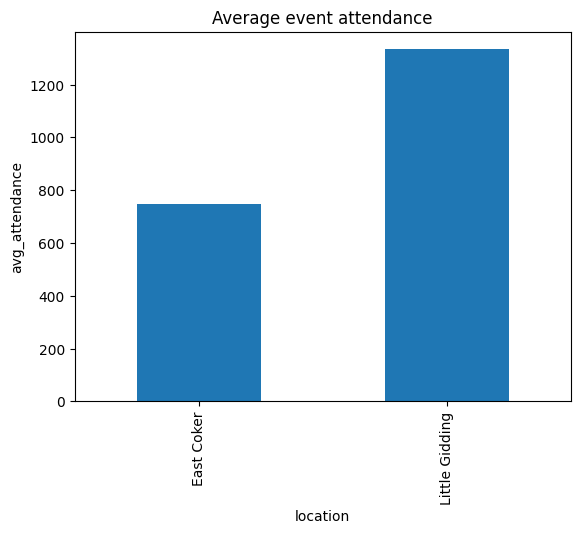

In [86]:
events.groupby('location')['event_attendance'].mean().plot(kind='bar', ylabel='avg_attendance', title="Average event attendance")

#### The above plot shows tha average event attendance at Little Gidding is significantly higher that East Coker.

#### Seperating the data for East Coker and Little Gidding.

In [10]:
events_EC = events[events['location'] == 'East Coker']
events_EC.drop('location', axis=1, inplace=True)
events_EC.set_index('date', inplace=True)
events_EC

,event_attendance
date,
2022-01-01,707
2022-01-08,563
2022-01-15,757
2022-01-22,649
2022-01-29,799
...,...
2025-03-01,544
2025-03-08,875
2025-03-15,871


In [11]:
events_LG = events[events['location'] == 'Little Gidding']
events_LG

,date,event_attendance,location
1,2022-01-01,761,Little Gidding
3,2022-01-08,1186,Little Gidding
4,2022-01-10,1765,Little Gidding
11,2022-02-25,862,Little Gidding
13,2022-03-03,1868,Little Gidding
...,...,...,...
240,2025-02-26,1635,Little Gidding
241,2025-02-28,1965,Little Gidding
245,2025-03-15,1277,Little Gidding
247,2025-03-22,905,Little Gidding


In [12]:
events_LG.drop('location', axis=1, inplace=True)
events_LG.set_index('date', inplace=True)
events_LG

,event_attendance
date,
2022-01-01,761
2022-01-08,1186
2022-01-10,1765
2022-02-25,862
2022-03-03,1868
...,...
2025-02-26,1635
2025-02-28,1965
2025-03-15,1277


In [13]:
bookings_EC = bookings[bookings['location'] == 'East Coker']
bookings_EC

,booking_id,date,location
0,0,2022-01-01,East Coker
31,31,2022-01-01,East Coker
59,59,2022-01-01,East Coker
120,120,2022-01-01,East Coker
122,122,2022-01-01,East Coker
...,...,...,...
227881,227881,2024-12-31,East Coker
227882,227882,2024-12-31,East Coker
227883,227883,2024-12-31,East Coker
227884,227884,2024-12-31,East Coker


In [14]:
bookings_EC = bookings_EC.groupby(by='date').count().reset_index()
bookings_EC

,date,booking_id,location
0,2022-01-01,124,124
1,2022-01-02,42,42
2,2022-01-03,117,117
3,2022-01-04,204,204
4,2022-01-05,186,186
...,...,...,...
1091,2024-12-27,143,143
1092,2024-12-28,163,163
1093,2024-12-29,101,101
1094,2024-12-30,157,157


In [15]:
bookings_LG = bookings[bookings['location'] == 'Little Gidding']
bookings_LG

,booking_id,date,location
1,1,2022-01-01,Little Gidding
2,2,2022-01-01,Little Gidding
3,3,2022-01-01,Little Gidding
4,4,2022-01-01,Little Gidding
5,5,2022-01-01,Little Gidding
...,...,...,...
227660,227660,2024-12-31,Little Gidding
227661,227661,2024-12-31,Little Gidding
227662,227662,2024-12-31,Little Gidding
227886,227886,2024-12-31,Little Gidding


In [16]:
bookings_LG = bookings_LG.groupby(by='date').count().reset_index()
bookings_LG

,date,booking_id,location
0,2022-01-01,118,118
1,2022-01-02,26,26
2,2022-01-03,21,21
3,2022-01-04,7,7
4,2022-01-05,16,16
...,...,...,...
1079,2024-12-27,17,17
1080,2024-12-28,65,65
1081,2024-12-29,61,61
1082,2024-12-30,49,49


## Analysis and Modelling for East Coker

In [17]:
# Preparing the bookings table for East Coker.

bookings_EC.drop(columns='location', inplace=True)
bookings_EC = bookings_EC.rename(columns={'booking_id':'number_of_bookings'})
bookings_EC

,date,number_of_bookings
0,2022-01-01,124
1,2022-01-02,42
2,2022-01-03,117
3,2022-01-04,204
4,2022-01-05,186
...,...,...
1091,2024-12-27,143
1092,2024-12-28,163
1093,2024-12-29,101
1094,2024-12-30,157


In [18]:
bookings_EC.isna().sum()

date                  0
number_of_bookings    0
dtype: int64

In [19]:
bookings_EC.set_index('date', inplace=True)
bookings_EC

,number_of_bookings
date,
2022-01-01,124
2022-01-02,42
2022-01-03,117
2022-01-04,204
2022-01-05,186
...,...
2024-12-27,143
2024-12-28,163
2024-12-29,101


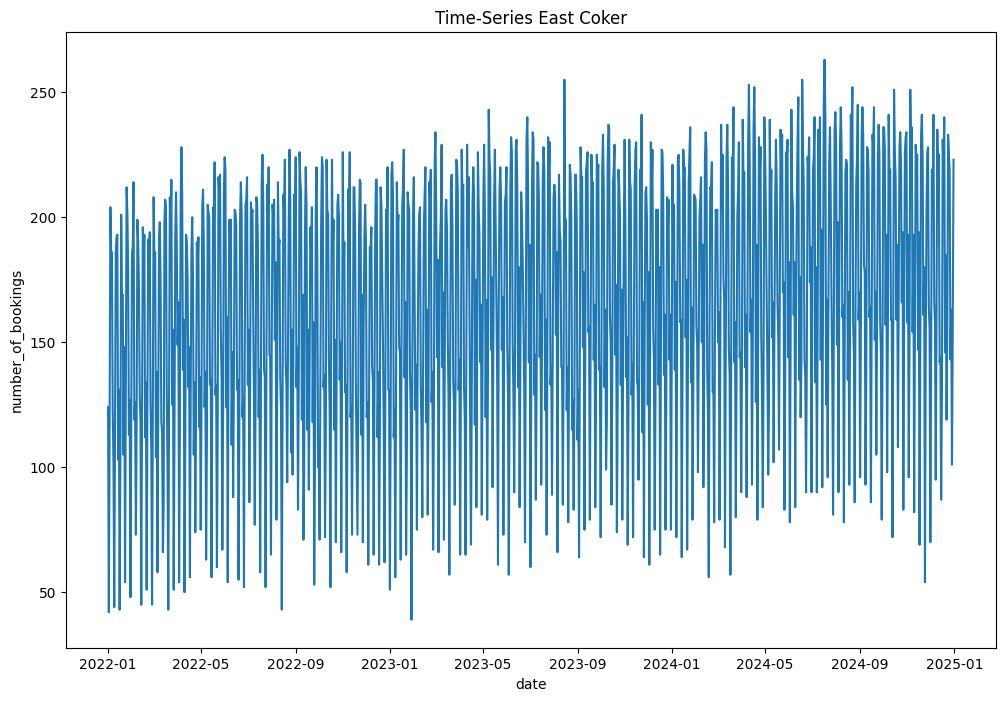

In [85]:
plt.figure(figsize=(12,8))
sns.lineplot(data=bookings_EC, x='date', y='number_of_bookings')
plt.title("Time-Series East Coker")
plt.show()

##### In the obove graph we can see an upward trend over time. There is definately some seasonality visible, so we zoom in on a month so see it more clearly.

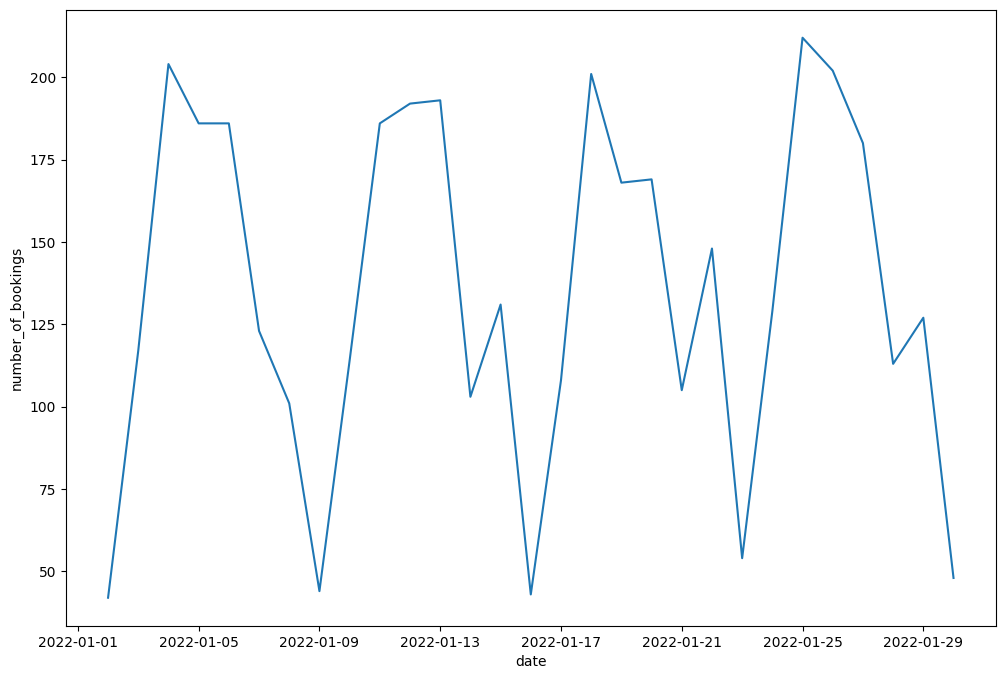

In [21]:
plt.figure(figsize=(12,8))
sns.lineplot(data=bookings_EC.iloc[1:30], x='date', y='number_of_bookings')
plt.show()

##### Zooming in on a particular month, we can obeserve a seasonality of 7 days. The data is variable day-to-day, suggesting demand fluctuates regularly, likely due to weekday vs. weekend effects.

#### Checking the stationarity of the dataset using Dickey-Fuller Test.

#### Here the null hypothesis is that the Time Series is non-stationary

In [22]:
def check_stationarity(data):
    """Inputs a time series, performs the Dickey-Fuller test and prints the results."""

    adfuller_result = adfuller(data)
    p_value = adfuller_result[1]
    if p_value < 0.05:
        print('The time series is stationary.')
    else:
        print('The time series is non-stationary.')

check_stationarity(bookings_EC)

The time series is non-stationary.


In [23]:
ts_data = bookings_EC['number_of_bookings']

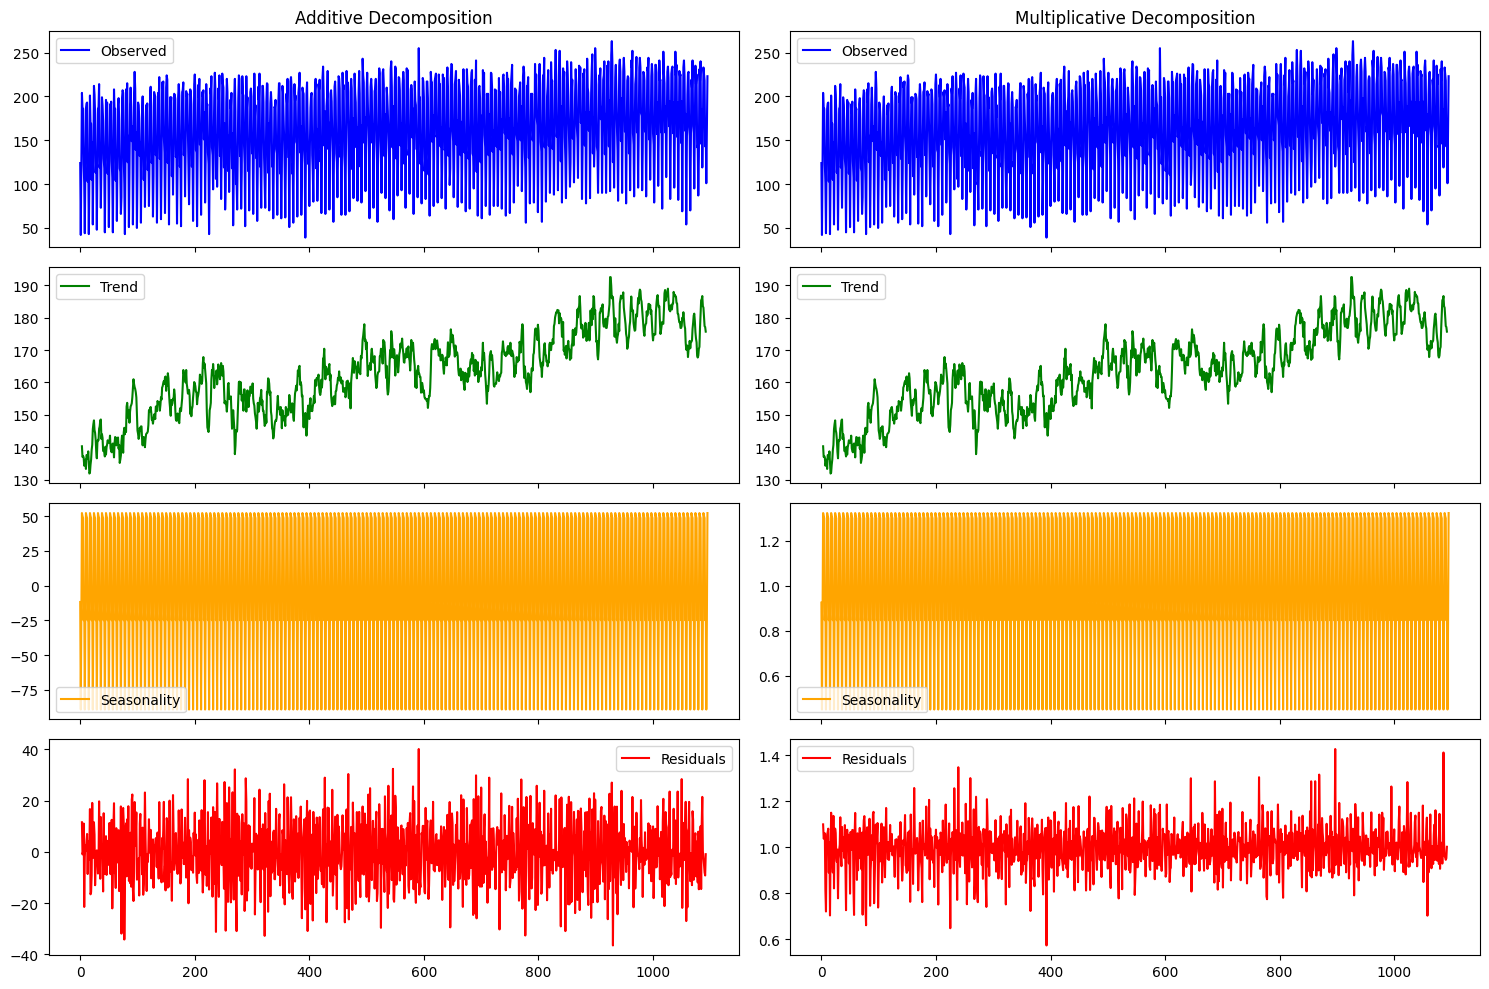

In [24]:
# Decomposing the time series for both 'additive' and 'multiplicative' models for comparison.

def decompose_plots(ts_data):

    decomposition_add = seasonal_decompose(ts_data.values, period=7, model='additive')
    decomposition_mul = seasonal_decompose(ts_data.values, period=7, model='multiplicative')

    trend_additive, seasonal_additive, residual_additive = decomposition_add.trend, decomposition_add.seasonal, decomposition_add.resid
    trend_mul, seasonal_mul, residual_mul = decomposition_mul.trend, decomposition_mul.seasonal, decomposition_mul.resid

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10), sharex=True)

    axes[0, 0].set_title("Additive Decomposition", fontsize=12)
    axes[0, 1].set_title("Multiplicative Decomposition", fontsize=12)

    axes[0, 0].plot(ts_data.values, label='Observed', color='blue')
    axes[0, 0].legend(loc='best')

    axes[0, 1].plot(ts_data.values, label='Observed', color='blue')
    axes[0, 1].legend(loc='best')

    axes[1, 0].plot(trend_additive, label='Trend', color='green')
    axes[1, 0].legend(loc='best')

    axes[1, 1].plot(trend_mul, label='Trend', color='green')
    axes[1, 1].legend(loc='best')


    axes[2, 0].plot(seasonal_additive, label='Seasonality', color='orange')
    axes[2, 0].legend(loc='best')

    axes[2, 1].plot(seasonal_mul, label='Seasonality', color='orange')
    axes[2, 1].legend(loc='best')


    axes[3, 0].plot(residual_additive, label='Residuals', color='red')
    axes[3, 0].legend(loc='best')

    axes[3, 1].plot(residual_mul, label='Residuals', color='red')
    axes[3, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()

decompose_plots(ts_data)

#### From the above graph we can observe that there is no significant difference in trend and seasonality of either additive or multiplicative decompositions. No growth or shrinkage in the seasonality over time suggest we are good to go with an additive model for predictions.

#### The residual plot seems random, but as per Dickey Fuller test the time series is still non-stationary.

#### Lets now perform one order differencing (d=1) and see if the time series becomes stationary.

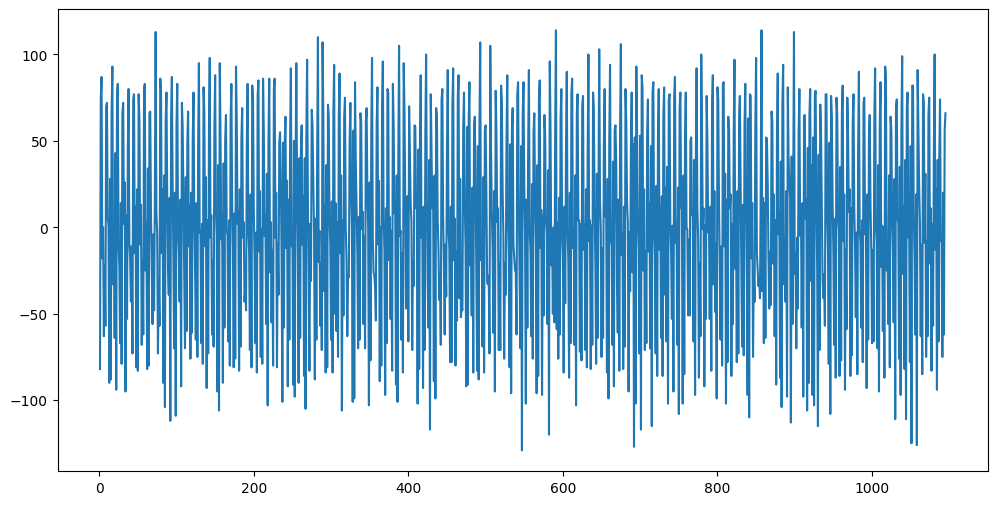

In [25]:
# Shifting the time series by one unit and taking the difference.

ts_diff = ts_data - ts_data.shift(1)
plt.figure(figsize=(12,6))
sns.lineplot(ts_diff.values)
plt.show()

<Figure size 1200x600 with 0 Axes>

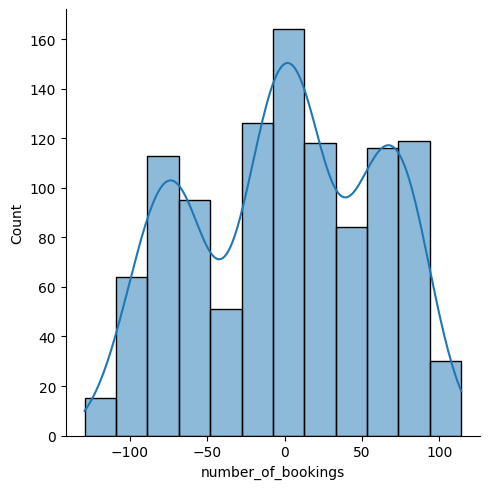

In [26]:
# Plotting the residuals to check for normality.
plt.figure(figsize=(12,6))
sns.displot(ts_diff, kde=True)
plt.show()

#### The above plot show a normal distribution.

In [27]:
# Checking if differencing by one order makes the time series stationary.
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)

The time series is stationary.


#### One order differencing has made the time series stationary.

#### Plotting the ACF and PACF plots decide the 'p' and 'q' value required for our ARIMA, SARIMA and SARIMAX model.

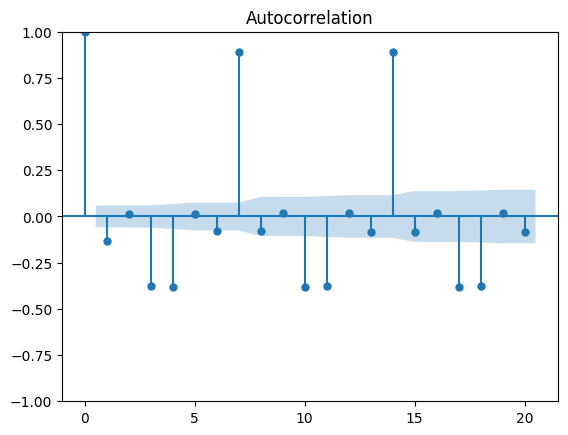

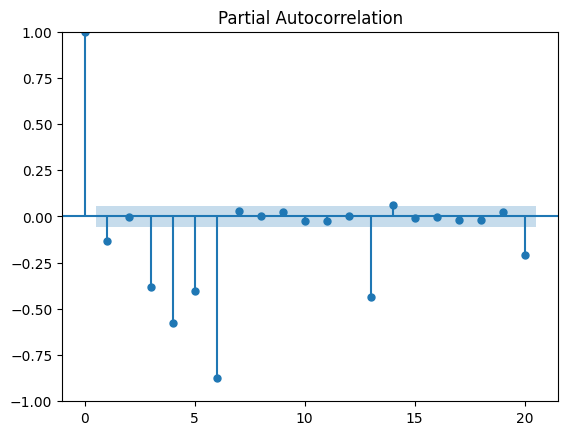

In [28]:
acf = plot_acf(ts_diff, lags=20)
pacf = plot_pacf(ts_diff, lags=20)

#### Interpreting the above plots:

##### For the value of 'q' we look at the ACF plot. We can clearly observe that there is a significant correlation after 7 lags. Hence we choose our q value as 7

##### For the value of 'p' we look at the PACF plot. Significant correlation exist after 6 lags. We choose p as 6.

##### We saw earlier that our time series became stationary after one order differencing, so d=1

##### q = 7, p = 6, d = 1

In [29]:
def performance(actual, predicted):
    """Calculates performance metrics for the predictions."""
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

def train_test_split(data):
    """Used to split the time series into training and testing."""
    train = ts_data[:-20]
    test = ts_data[-20:]

    return train, test

In [30]:
# Splitting the data for training and testing.

train, test = train_test_split(ts_data)

In [31]:
test = pd.DataFrame(test)
test.head()

,number_of_bookings
date,
2024-12-12,225
2024-12-13,142
2024-12-14,144
2024-12-15,87
2024-12-16,131


#### ARIMA Model

MAE : 11.259
RMSE : 14.625
MAPE: 0.076


<Axes: xlabel='date'>

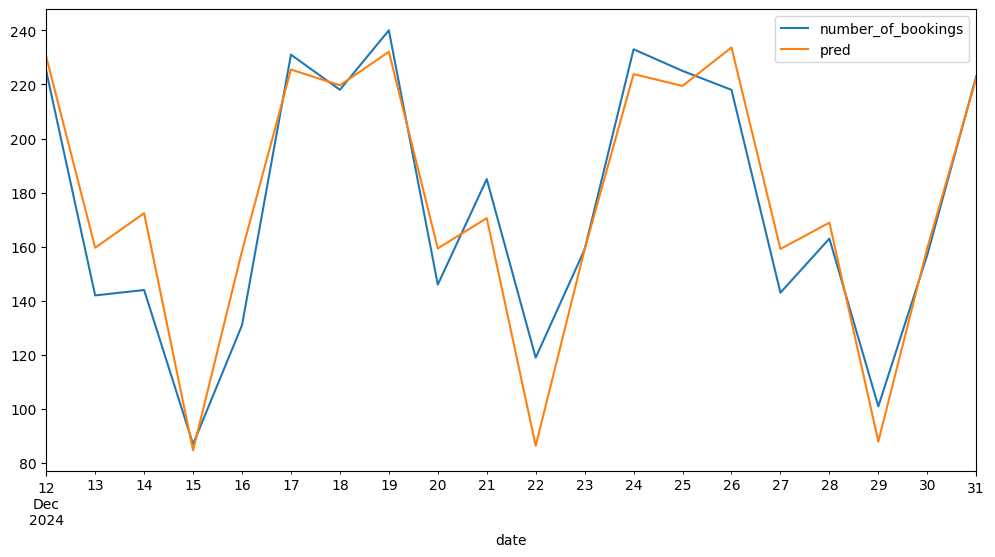

In [32]:
model_ARIMA = SARIMAX(train, order=(6, 1, 7))
model_ARIMA_fitted = model_ARIMA.fit(disp=0)

test['pred'] = model_ARIMA_fitted.forecast(steps=20)

performance(test['number_of_bookings'], test['pred'])
test.plot(figsize=(12, 6))

#### SARIMA Model

MAE : 10.919
RMSE : 13.514
MAPE: 0.072


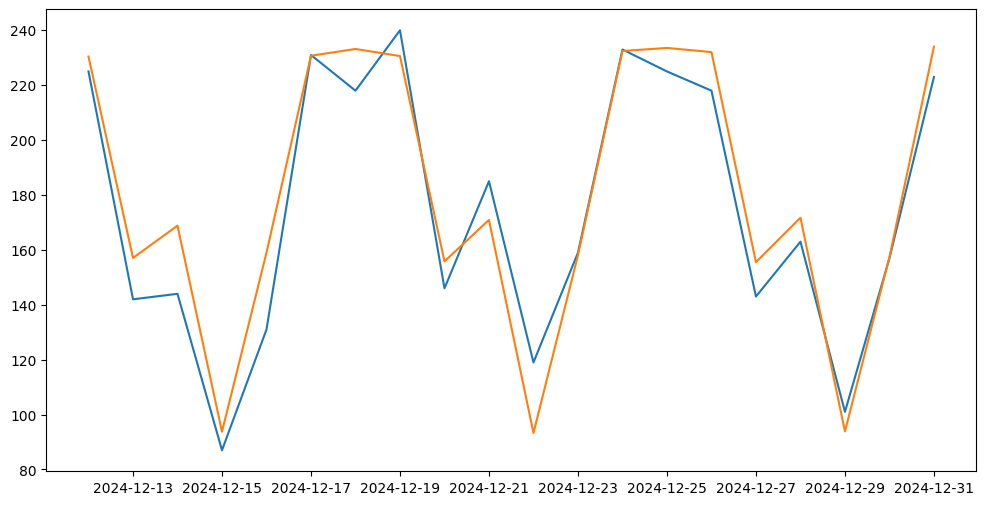

In [33]:
model_SARIMA = SARIMAX(train, order=(6, 1, 6), seasonal_order=(2, 1, 2, 7))
model_SARIMA_fitted = model_SARIMA.fit(disp=0)

test['pred_sarima'] = model_SARIMA_fitted.forecast(steps=20)

performance(test['number_of_bookings'], test['pred_sarima'])
plt.figure(figsize=(12, 6))
plt.plot(test[['number_of_bookings', 'pred_sarima']])
plt.show()

#### SARIMAX Model

#### For SARIMAX model with exogenous events data lets merge it with original time series.

In [34]:
merged_df = (
    ts_data.reset_index()
    .merge(events_EC.reset_index(), how='left', on='date')
    .set_index('date')
)
merged_df['event_attendance'] = merged_df['event_attendance'].fillna(0)
merged_df.head()

,number_of_bookings,event_attendance
date,,
2022-01-01,124,707.0
2022-01-02,42,0.0
2022-01-03,117,0.0
2022-01-04,204,0.0
2022-01-05,186,0.0


##### Visualizing impact of events on bookings.

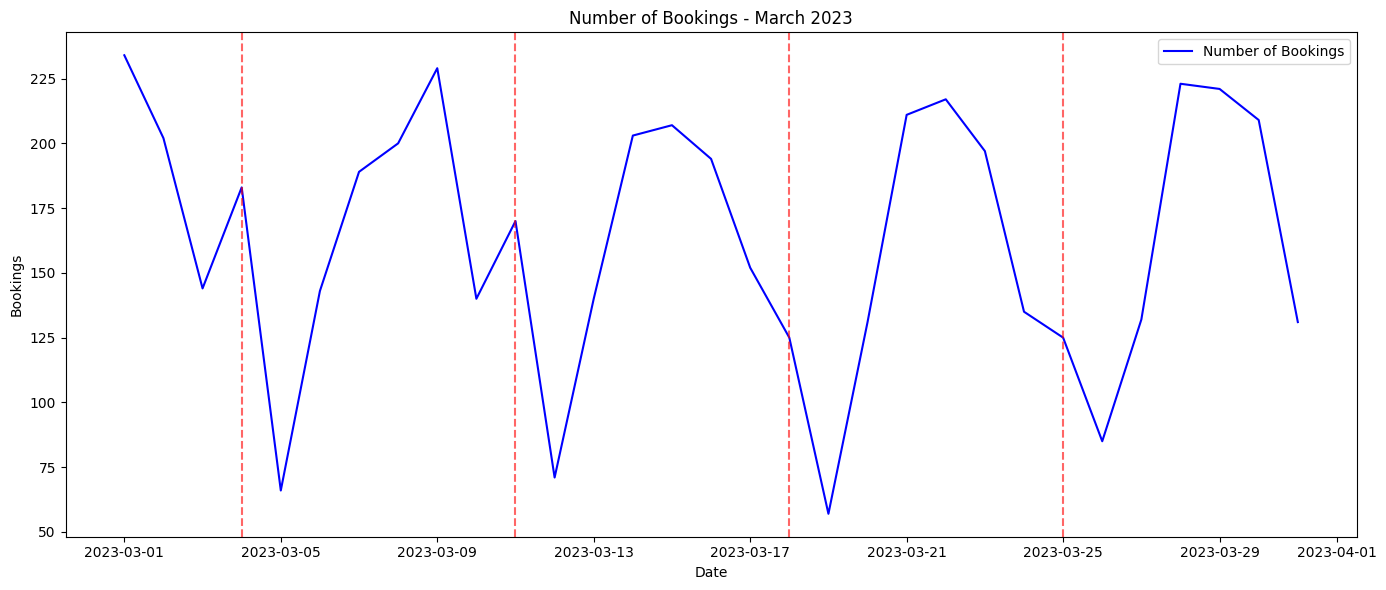

In [35]:
# Filtering data to a specific month, e.g., March 2023
zoom_df = merged_df.loc['2023-03']

plt.figure(figsize=(14, 6))
plt.plot(zoom_df.index, zoom_df['number_of_bookings'], label='Number of Bookings', color='blue')

# Adding vertical lines for events in that month
event_dates = zoom_df[zoom_df['event_attendance'] > 0].index
for event_date in event_dates:
    plt.axvline(event_date, color='red', linestyle='--', alpha=0.6)

plt.title('Number of Bookings - March 2023')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.tight_layout()
plt.show()

#### In the above graph we see how events impact the bookings. It is interesting to see that on the day of the event(represented by red lines) the bookings are low, but for the days leading up to the event the bookings are high, this suggests that people make the bookings in advance which makes sense.

In [36]:
# Splitting into training and testing.

train_SARIMAX = merged_df[:-20]
test_SARIMAX = merged_df[-20:]

In [37]:
# Defining period of predictions.

start = len(train_SARIMAX)
end = len(train_SARIMAX) + len(test_SARIMAX) - 1

In [38]:
model_SARIMAX = SARIMAX(train_SARIMAX['number_of_bookings'], order=(6, 1, 6), seasonal_order=(1, 1, 1, 7), exog=train_SARIMAX['event_attendance'])
model_SARIMAX_fitted = model_SARIMAX.fit(disp=0)

predictions = model_SARIMAX_fitted.predict(exog=test_SARIMAX['event_attendance'], start=start, end=end)

performance(test_SARIMAX['number_of_bookings'], predictions)

MAE : 10.201
RMSE : 12.644
MAPE: 0.067


#### Given that the SARIMAX model performs the best with a MAPE of 6.7%, we use it to make the forecasts.

##### Lets get exogeneous events data between 1st of January 2025 and the 31st of March 2025, which we will use to make the forecasts.

In [39]:
forecast_dates = pd.date_range(start="2025-01-01", end="2025-03-31", freq='D')
steps = len(forecast_dates)

In [40]:
# Getting the exogenous data for the forecast period.

forecast_exog = events_EC["2025-01-01":"2025-03-31"]
forecast_exog

,event_attendance
date,
2025-01-04,831
2025-01-11,868
2025-01-18,753
2025-01-25,894
2025-02-01,973
2025-02-08,516
2025-02-15,744
2025-02-22,880
2025-03-01,544


##### Since we are making predictions for 90 day period, we need to make the length of exogeneous table 90 too.

In [41]:
temp = pd.date_range(start="2025-01-01", end="2025-03-31", freq='D')
temp = pd.DataFrame(temp)
temp.columns = ['date']
forecast_exog = pd.merge(temp, forecast_exog, on='date', how='left')
forecast_exog['event_attendance'].fillna(0, inplace=True)
forecast_exog.set_index('date', inplace=True)
forecast_exog

,event_attendance
date,
2025-01-01,0.0
2025-01-02,0.0
2025-01-03,0.0
2025-01-04,831.0
2025-01-05,0.0
...,...
2025-03-27,0.0
2025-03-28,0.0
2025-03-29,634.0


#### Now lets retrain the model on the full time series and get the forecasts.

In [42]:
model_SARIMAX_final_EC = SARIMAX(merged_df['number_of_bookings'], order=(6, 1, 6), seasonal_order=(1, 1, 1, 7), exog=merged_df['event_attendance'])
model_SARIMAX_final_EC_fitted = model_SARIMAX_final_EC.fit(disp=0)

forecast_values_EC = model_SARIMAX_final_EC_fitted.forecast(steps=steps, exog=forecast_exog)
forecast_values_EC

2025-01-01    232.380751
2025-01-02    228.122730
2025-01-03    151.526046
2025-01-04    181.446806
2025-01-05     91.129547
                 ...    
2025-03-27    233.235253
2025-03-28    159.637368
2025-03-29    160.899977
2025-03-30     95.313257
2025-03-31    159.863986
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

## Analysis and Modelling for Little Gidding

In [43]:
bookings_LG

,date,booking_id,location
0,2022-01-01,118,118
1,2022-01-02,26,26
2,2022-01-03,21,21
3,2022-01-04,7,7
4,2022-01-05,16,16
...,...,...,...
1079,2024-12-27,17,17
1080,2024-12-28,65,65
1081,2024-12-29,61,61
1082,2024-12-30,49,49


In [44]:
#Preparing the bookings table for Little Gidding.
bookings_LG.drop(columns='location', inplace=True)
bookings_LG = bookings_LG.rename(columns={'booking_id':'number_of_bookings'})
bookings_LG

,date,number_of_bookings
0,2022-01-01,118
1,2022-01-02,26
2,2022-01-03,21
3,2022-01-04,7
4,2022-01-05,16
...,...,...
1079,2024-12-27,17
1080,2024-12-28,65
1081,2024-12-29,61
1082,2024-12-30,49


In [45]:
# Checking for missing values.
bookings_LG.isna().sum()

date                  0
number_of_bookings    0
dtype: int64

In [46]:
# Setting date as the index.
bookings_LG.set_index('date', inplace=True)
bookings_LG

,number_of_bookings
date,
2022-01-01,118
2022-01-02,26
2022-01-03,21
2022-01-04,7
2022-01-05,16
...,...
2024-12-27,17
2024-12-28,65
2024-12-29,61


#### Lets now plot and see the time series for Little Gidding.

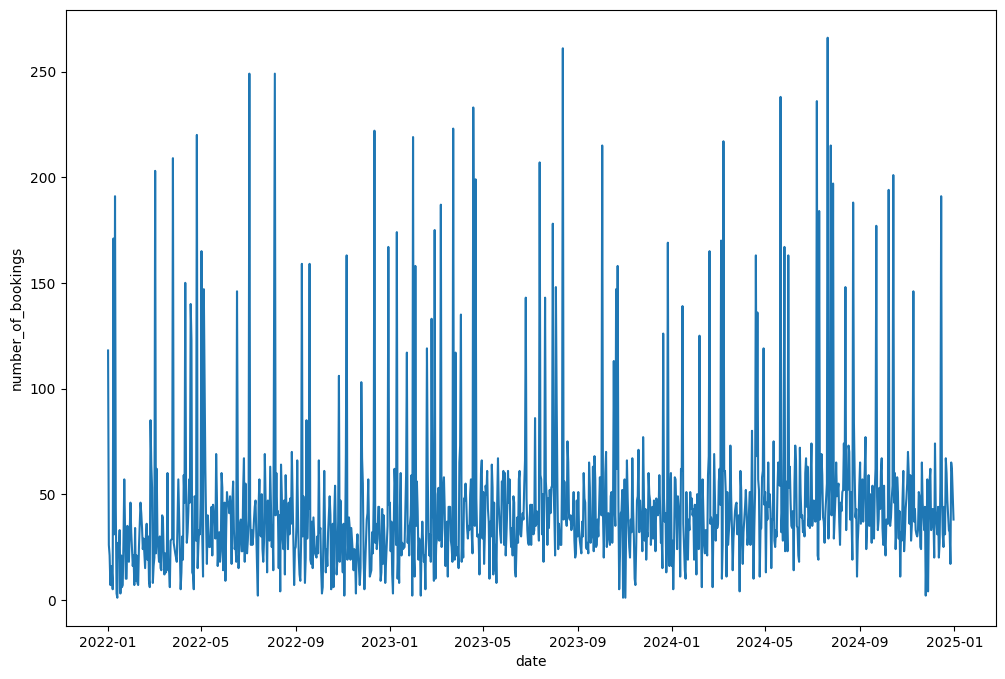

In [47]:
plt.figure(figsize=(12,8))
sns.lineplot(data=bookings_LG, x='date', y='number_of_bookings')
plt.show()

##### The above plot suggests that the time series is very random, with no visible trend. There seems to be a yearly seasonality but we can't be sure.

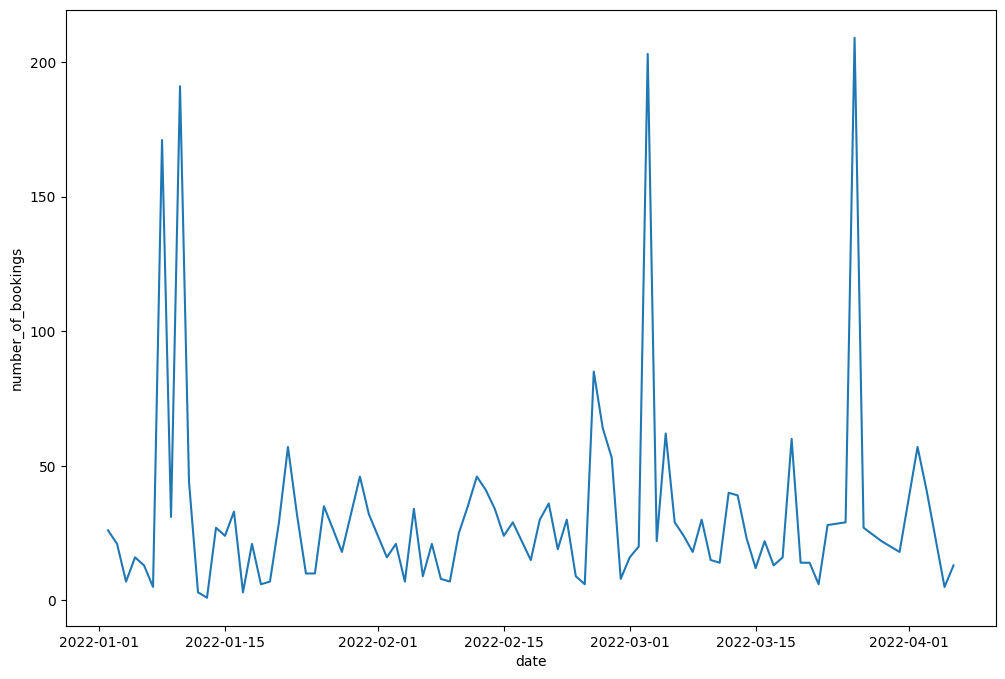

In [48]:
plt.figure(figsize=(12,8))
sns.lineplot(data=bookings_LG.iloc[1:90], x='date', y='number_of_bookings')
plt.show()

#### Above, we zoom in on the time series. Its looks random with spikes at certain places.

#### Lets now check if the time series for Little Gidding is stationary or not.

In [49]:
check_stationarity(bookings_LG)

The time series is stationary.


#### Since the time series is already stationary we do not need to perform differencing.

In [50]:
ts_data = bookings_LG['number_of_bookings']

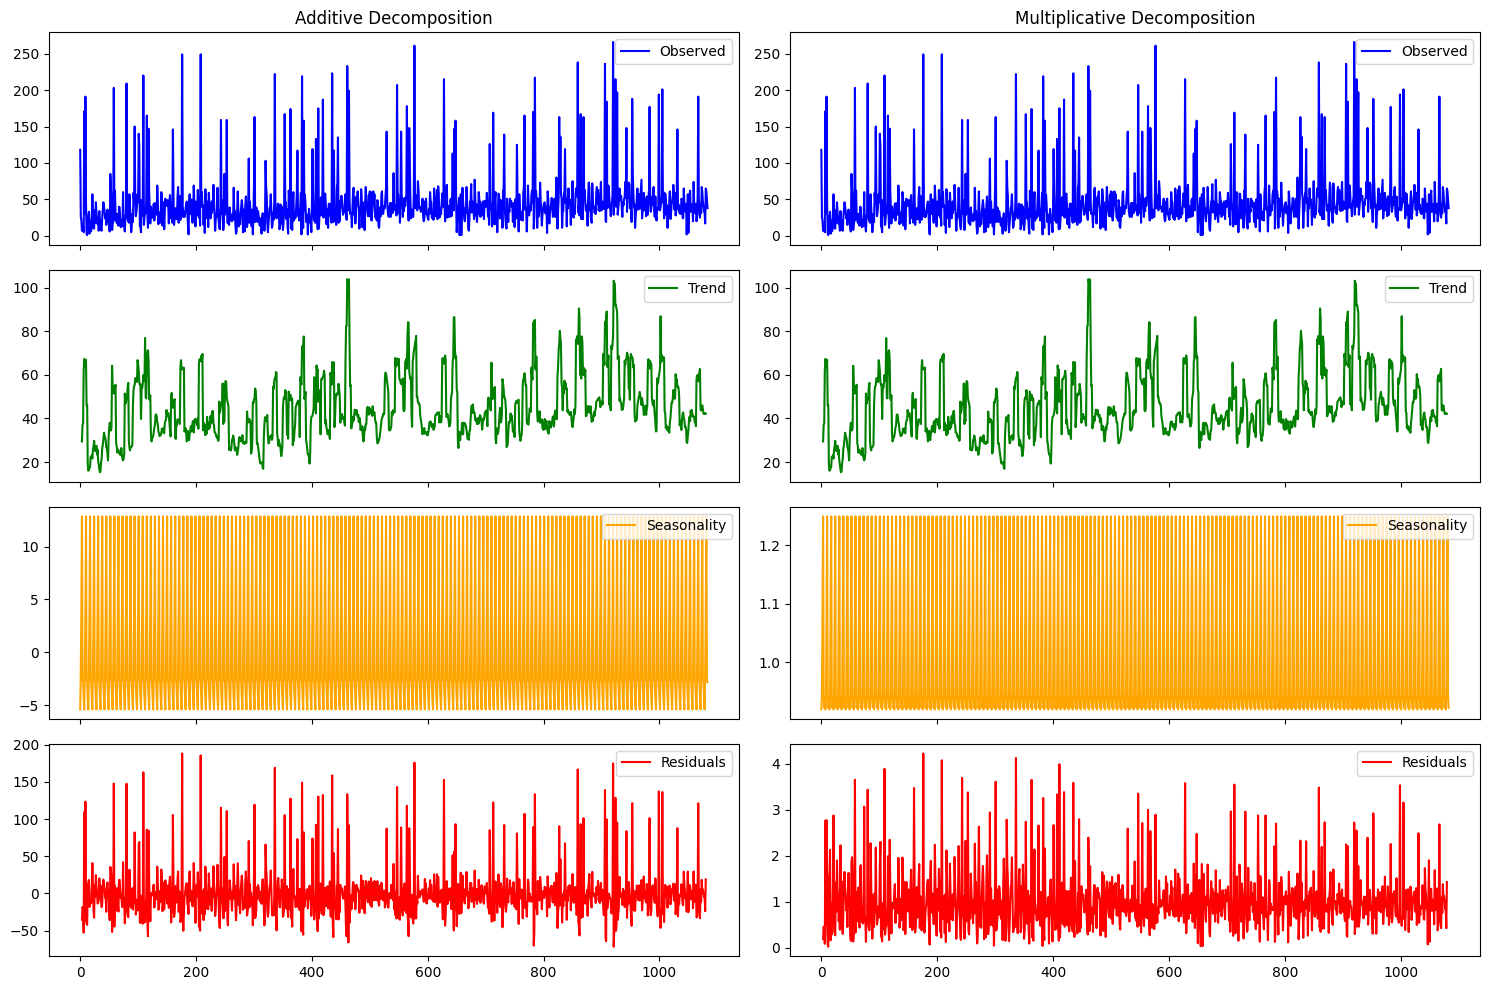

In [51]:
decompose_plots(ts_data)

#### From the above graph we can observe that there is no visible trend or seasonality in either of the decompositions.

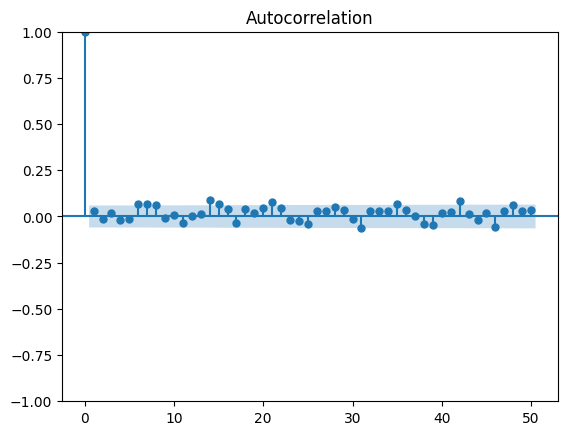

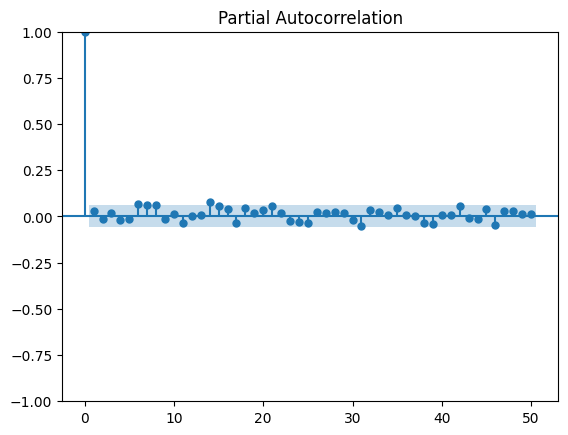

In [52]:
acf = plot_acf(ts_data, lags=50)
pacf = plot_pacf(ts_data, lags=50)

#### From the plots above we can see that there is no significant correlation in any of the lags. This suggests that the time series is random or white noise. It might not be possible to make reliable predictions.

<Figure size 1200x600 with 0 Axes>

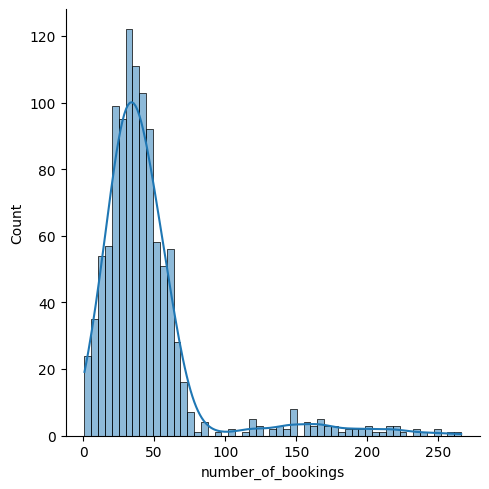

In [53]:
plt.figure(figsize=(12,6))
sns.displot(ts_data, kde=True)
plt.show()

#### The above histplot shows a right skewed distribution of the time series data. There are a lot of outliers in the data which we see as spikes in the time series plot.

#### Since this time series is completely random with no trends or seasonality, we cannot forecast using SARIMAX models. But just for the sake of providing forecast for the given period, lets see what results can we get.

In [54]:
merged_df2 = (
    ts_data.reset_index()
    .merge(events_LG.reset_index(), how='left', on='date')
    .set_index('date')
)
merged_df2['event_attendance'] = merged_df2['event_attendance'].fillna(0)
merged_df2.head()

,number_of_bookings,event_attendance
date,,
2022-01-01,118,761.0
2022-01-02,26,0.0
2022-01-03,21,0.0
2022-01-04,7,0.0
2022-01-05,16,0.0


In [55]:
# Splitting the data dor training and testing. Last 20 points are choosen for testing and rest for training.

train_SARIMAX = merged_df2[:-20]
test_SARIMAX = merged_df2[-20:]

In [56]:
# Defining the period where the predicitons need to be made.

start = len(train_SARIMAX)
end = len(train_SARIMAX) + len(test_SARIMAX) - 1

#### Training SARIMAX model for Little Gidding.

#### p and q are taken as 6 from looking at the ACF and PACF plots. d=0 since the time series was already stationary.

In [57]:
model_SARIMAX = SARIMAX(train_SARIMAX['number_of_bookings'], order=(6, 0, 6), seasonal_order=(1, 1, 1, 7), exog=train_SARIMAX['event_attendance'])
model_SARIMAX_fitted = model_SARIMAX.fit(disp=0)

predictions = model_SARIMAX_fitted.predict(exog=test_SARIMAX['event_attendance'], start=start, end=end)

performance(test_SARIMAX['number_of_bookings'], predictions)

MAE : 10.863
RMSE : 12.635
MAPE: 0.294


#### The mean absolute percentage error is 29.4% which is very high. This is likely due to the randomness of the time series.

#### Lets prepare the exogenous data for Little Gidding.

In [58]:
forecast_dates = pd.date_range(start="2025-01-01", end="2025-03-31", freq='D')
steps = len(forecast_dates)

In [60]:
forecast_exog_LG = events_LG["2025-01-01":"2025-03-31"]
forecast_exog_LG

,event_attendance
date,
2025-01-12,1392
2025-01-17,1681
2025-02-02,956
2025-02-26,1635
2025-02-28,1965
2025-03-15,1277
2025-03-22,905
2025-03-30,1510


In [61]:
temp2 = pd.date_range(start="2025-01-01", end="2025-03-31", freq='D')
temp2 = pd.DataFrame(temp)
temp2.columns = ['date']
forecast_exog_LG = pd.merge(temp2, forecast_exog_LG, on='date', how='left')
forecast_exog_LG['event_attendance'].fillna(0, inplace=True)
forecast_exog_LG.set_index('date', inplace=True)
forecast_exog_LG

,event_attendance
date,
2025-01-01,0.0
2025-01-02,0.0
2025-01-03,0.0
2025-01-04,0.0
2025-01-05,0.0
...,...
2025-03-27,0.0
2025-03-28,0.0
2025-03-29,0.0


#### Forecasting for Little Gidding.

In [62]:
model_SARIMAX_final_LG = SARIMAX(merged_df2['number_of_bookings'], order=(6, 1, 6), seasonal_order=(1, 1, 1, 7), exog=merged_df2['event_attendance'])
model_SARIMAX_final_LG_fitted = model_SARIMAX_final_LG.fit(disp=0)

forecast_values_LG = model_SARIMAX_final_LG_fitted.forecast(steps=steps, exog=forecast_exog_LG)
forecast_values_LG

1084     39.822598
1085     32.836494
1086     31.234617
1087     58.225604
1088     60.081334
           ...    
1169     35.531555
1170     35.454413
1171     59.478004
1172    212.206825
1173     38.404141
Name: predicted_mean, Length: 90, dtype: float64

In [78]:
# Assigning datetime index
forecast_values_LG.index = forecast_exog_LG.index

forecast_values_LG.head(90)

,Little Gidding
date,
2025-01-01,39.822598
2025-01-02,32.836494
2025-01-03,31.234617
2025-01-04,58.225604
2025-01-05,60.081334
...,...
2025-03-27,35.531555
2025-03-28,35.454413
2025-03-29,59.478004


#### The above forecast for Little Gidding is unreliable given the high MAPE value.

#### Preparing the CSV file with forecasts for submission.

In [75]:
forecast_values_EC = pd.DataFrame(forecast_values_EC)
forecast_values_EC.columns = ['East Coker']
forecast_values_EC

,East Coker
2025-01-01,232.380751
2025-01-02,228.122730
2025-01-03,151.526046
2025-01-04,181.446806
2025-01-05,91.129547
...,...
2025-03-27,233.235253
2025-03-28,159.637368
2025-03-29,160.899977
2025-03-30,95.313257


In [84]:
forecasts_final = pd.concat([forecast_values_EC, forecast_values_LG], axis=1)
forecasts_final = forecasts_final.round()
forecasts_final

,East Coker,Little Gidding
2025-01-01,232.0,40.0
2025-01-02,228.0,33.0
2025-01-03,152.0,31.0
2025-01-04,181.0,58.0
2025-01-05,91.0,60.0
...,...,...
2025-03-27,233.0,36.0
2025-03-28,160.0,35.0
2025-03-29,161.0,59.0
2025-03-30,95.0,212.0


In [88]:
# Saving the forecasts in a CSV file.

forecasts_final.to_csv('filename.csv', index=False)

## Time Series Analysis Findings

### Key Observations from the Modeling Process

The analysis revealed fundamentally different time series characteristics between the two locations. East Coker exhibited a well-structured time series with clear weekly seasonality (7-day cycles), an upward trend over time, and non-stationary behavior that became stationary after first-order differencing. The SARIMAX model performed well for East Coker with reasonable forecast accuracy, successfully capturing the weekday vs. weekend booking patterns and responding appropriately to exogenous event data. The strong seasonal patterns and predictable trends made this location highly suitable for traditional time series forecasting methods.

In stark contrast, Little Gidding presented a highly irregular and random time series that was already stationary but lacked discernible trends or seasonal patterns. The ACF and PACF plots showed no significant correlations at any lags, indicating the data resembles white noise with frequent outliers and spikes. Despite attempting SARIMAX modeling, the forecast achieved a poor MAPE of 29.4%, highlighting the fundamental unpredictability of this location's booking patterns. The right-skewed distribution with numerous outliers suggests that Little Gidding's demand is driven by irregular, possibly event-driven factors that don't follow traditional seasonal or trend-based patterns, making reliable forecasting extremely challenging with conventional time series methods.